In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm import tqdm
import os
import torch
from torch_geometric.data import Data

def path_link(path:str):
    sys.path.append(path)

path_link('/master/code/lib')

import simulation_v2 as sim
import features as ft
import utils.loading as load
import utils.testing_gen as gen
from utils.tools import array2List, makedirs
import utils.nn_gen as nn_gen

yessss


In [2]:
#PATH = 'master/code/runs1'
#PATH = 'master/code/runs2'
#PATH = ['/master/code/analyze_models/exps/test_new_activation_0']
PATH = ['/master/code/analyze_models/exps/exp-test']

#DISPLAY_PATH = 'master/code/display_l1'
#DISPLAY_PATH = '/master/code/display_l1_2'
#DISPLAY_PATH = ['/master/code/analyze_models/display/test_new_activation_0']
DISPLAY_PATH = ['/master/code/analyze_models/display/exp-test']

MODEL_PATH = '/master/code/models/mod_base'

NB_SIM = 10

### Rollout MSE function

In [26]:
def MSE_rollout(roll, sim, display:bool = False):
    x = np.arange(roll.shape[0])
    vals = ((roll - sim) ** 2).reshape(x.shape[0], -1)
    y = np.mean(vals, axis=1)
    std = np.std(vals, axis=1)

    if display:
        plt.plot(x, y, 'blue')
        plt.fill_between(x, y-std, y+std, zorder=  2, alpha = 0.4)
        plt.xlabel('Time')
        plt.ylabel('Rollout MSE')
        plt.grid(zorder = 1)

    return x, y


def applyMSE_rollout(simList, predList, color = 'blue', display:bool = False):

    res = np.zeros((len(simList), simList[0].shape[0]))

    for i in range(len(simList)):
        _, res[i] = MSE_rollout(predList[i], simList[i])

    res = np.mean(res, axis = 0)

    x = np.arange(res.shape[0])
    if display:
        plt.plot(x, res, color)
        #std = np.std(res, axis = 0)
        #plt.fill_between(x, res-std, res+std, zorder=  2, alpha = 0.4)
        plt.xlabel('Timesteps')
        plt.ylabel('Rollout MSE')
        plt.grid(zorder = 1)

### MSD functions

In [45]:
def MSD_comp(traj, tau):
    T = traj.shape[0]
    i = np.arange(T - tau)
    j = i + tau

    return np.linalg.norm(traj[j, :, :] - traj[i, :, :], axis=-1)**2


def MSD(traj: np.array)-> np.array:
    """
    Allows to compute the Mean Squared Displacement of the trajectories for all timestamps
    
    Args:
    -----
    - `traj`: np.array of N trajectories of length T [NxT]
    
    Output:
    -------
    Mean Squared Displacement for all timestamps
    """

    res = []
    T = traj.shape[0]
    
    for tau in range(1, T):
        val = np.mean(np.mean(MSD_comp(traj, tau), axis=0), axis=0)
        res.append(val)

    return res

def applyMSD(sims:list, display:bool = False, color:str = 'blue')->np.array:
    """ 
    Function to apply MSD to a group of simulations

    NOTE: test

    Args:
    -----
        - `sims` (list): list of simualtions

    Returns:
    --------
        np array [#Sim, T-1] of MSD computations
    """

    res = np.zeros((len(sims), sims[0].shape[0]-1))
    for i in range(len(sims)):
        sim = sims[i]
        res[i, :] = np.array(MSD(sim))


    if display:
        x = np.arange(sims[0].shape[0]-1)
        y = np.mean(res, axis = 0)
        std = np.std(res, axis = 0)
        plt.loglog(x, y, color = color, zorder = 1)
        plt.fill_between((x), (y - std), (y+std), color = color, alpha = 0.4, zorder = 2)
        
        plt.xlabel('Timesteps')
        plt.ylabel('MSD')

    return res

### Scattering function

In [72]:
def SelfIntermediateA(data, qval, verbose=False):
    T, N, _ = data.shape  # T is the number of time steps, N is the number of particles
    qval = np.array(qval, dtype=np.complex128)  # Ensure wave vector is complex for the computation
    
    SelfInt = np.empty((T-1,), dtype=np.complex128)
    
    for t in range(T-1):
        smax = T - t  
        
        rt = data[:smax]       
        rtplus = data[t:] 
        dr = rt - rtplus
        
        exp_factor = np.exp(1j * (qval[0] * dr[:, :, 0] + qval[1] * dr[:, :, 1]))
        
        SelfInt[t] = np.sum(exp_factor) / (N * smax)
    
    SelfInt_mod = np.sqrt(np.real(SelfInt)**2 + np.imag(SelfInt)**2)
    
    tval = np.linspace(0, T-1, num=T-1)
    
    if verbose:
        plt.figure(figsize=(10, 5))
        plt.semilogy(tval, SelfInt_mod, '.-r', lw=2)
        plt.xlabel('time')
        plt.ylabel('F_s(k,t)')
        plt.title('Self-intermediate Function')
        plt.grid(True)
        plt.ylim([0, 1])
        plt.show()
    
    return tval, SelfInt_mod, SelfInt


def applySelfScattering(simList, qval = None, display:bool = False, color = 'blue'):
    if qval is None:
        R = 1       #ngfjdngjdnsjhnjfnvjfdnbjvnfdjkgnfjkdhvbjkdhgjklhgjkd
        qval = 2*np.pi/R*np.array([1,0])

    res = np.zeros((len(simList),simList[0].shape[0]-1 ))

    for i in range(len(simList)):
        sim = simList[i]

        val = SelfIntermediateA(sim.copy(), qval.copy(), verbose = False)[1]
        res[i] = val

    r = np.mean(res, axis=0)
    delta = np.std(r, axis = 0)

    if display:
        #plt.figure(figsize=(10, 5))
        t = np.arange(1, simList[0].shape[0])

        plt.grid()
        plt.semilogy(t, r, color = color, lw=2)
       # plt.fill_between(t, r-delta, r+delta, color = color, alpha = 0.4)
        plt.xlabel('time')
        plt.ylabel('F_s(k,t)')
        plt.title('Self-intermediate Function')
        plt.grid(True)

    return r

### Main - test

In [6]:
if PATH is None:
        # check if listdir only outputs the last element (...)
        list_exp = [os.listdir('/master/code/analyze_models/exp/')]
        list_disp = [os.path.join('/master/code/analyze_models/display', list_exp[i]) for i in range(len(list_exp))]

else:
    list_exp = PATH
    list_disp = DISPLAY_PATH

params = gen.Parameters_Simulation()
data_gt = gen.get_mult_data(params, NB_SIM)
data_gt_list = array2List(data_gt)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 69.69it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 69.45it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 57.98it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 64.44it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 61.11it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:01<00:00, 77.33it/s] 


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 71.65it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 62.70it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:01<00:00, 77.63it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 149/149 [00:02<00:00, 71.93it/s]


In [7]:
exp = list_exp[0]
disp = list_disp[0]

In [8]:
model_list = load.findModels(exp)

4it [00:00, 45.94it/s]


In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model_path = model_list[0]
name_plot = load.getName(model_path)
model = load.loadModel(load.getModelName(name_plot), path=MODEL_PATH)
std_dict = torch.load(model_path)
model.load_state_dict(std_dict)
model = model.to(DEVICE)
model.eval()

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout


Simplest(
  (GNN): GN_edge()
)

In [10]:
preds = nn_gen.generate_sim_batch(model, data_gt)
data_preds = array2List(preds)

100%|██████████| 99/99 [00:37<00:00,  2.64it/s]


In [14]:
data_gt = data_gt[:, :preds.shape[1], :, :]
data_gt_list = [d[:preds.shape[1], :, :] for d in data_gt_list]

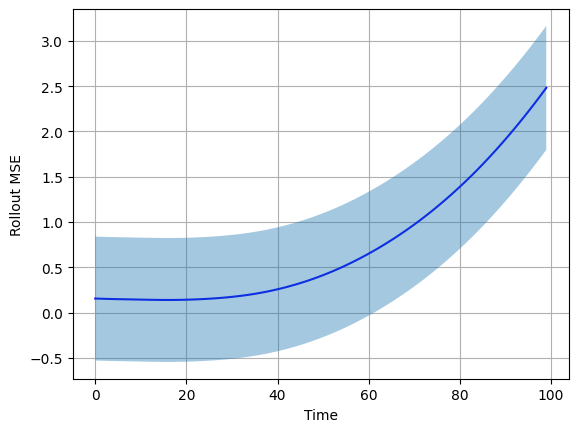

In [27]:
applyMSE_rollout(data_gt_list, data_preds, display = True)

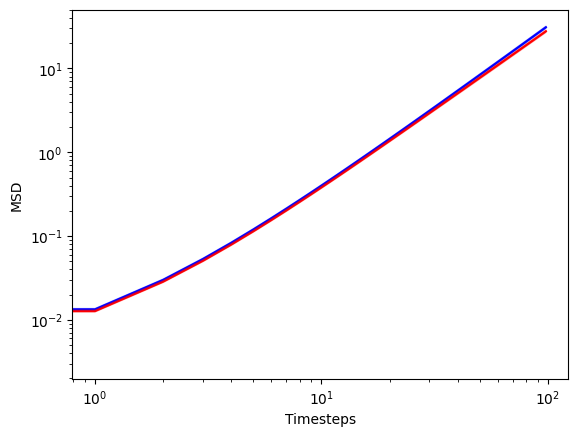

In [47]:
r = applyMSD(data_gt_list,
         display = True)

r = applyMSD(data_preds,
         display = True,
         color='red')

array([1.        , 0.96222361, 0.85323953, 0.68544194, 0.47766114,
       0.25348126, 0.06507447, 0.17307907, 0.31815711, 0.40886466,
       0.43851628, 0.40919721, 0.3297771 , 0.21460514, 0.08452131,
       0.078572  , 0.19034468, 0.2820023 , 0.33739861, 0.3524143 ,
       0.32926092, 0.27563544, 0.20433102, 0.13559351, 0.10536224,
       0.12087762, 0.14621479, 0.15683043, 0.14782841, 0.12610015,
       0.1096482 , 0.12807571, 0.16853677, 0.2059355 , 0.22665633,
       0.22380318, 0.19548938, 0.14437717, 0.07938094, 0.04076142,
       0.09005899, 0.15663895, 0.20693514, 0.23460934, 0.23793396,
       0.21980724, 0.18868626, 0.16014176, 0.15489134, 0.17741463,
       0.20965701, 0.2345653 , 0.2425281 , 0.22983873, 0.19736167,
       0.14998348, 0.09767704, 0.06960325, 0.1002775 , 0.14563751,
       0.18474862, 0.21068114, 0.22166255, 0.21875529, 0.20466792,
       0.18277465, 0.15650678, 0.12978251, 0.10463505, 0.08282037,
       0.0651373 , 0.06656134, 0.07931675, 0.10104185, 0.11942

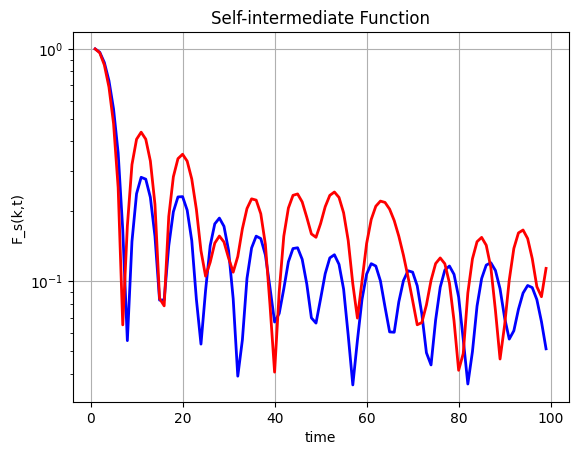

In [73]:
r = applySelfScattering(data_gt_list, 
                    qval = None, 
                    display = True, 
                    color = 'blue')


r = applySelfScattering(data_preds, 
                    qval = None, 
                    display = True, 
                    color = 'red')

In [67]:
print(r)

[1.         0.96758782 0.87413497 0.73020361 0.55150678 0.3568794
 0.16687571 0.05567599 0.14857677 0.23853995 0.28051044 0.27539197
 0.23004537 0.15645469 0.08313469 0.08334406 0.14247989 0.19943335
 0.23096278 0.23167396 0.20265142 0.14974854 0.08391049 0.05379909
 0.09146942 0.14249767 0.17691452 0.18731832 0.17265521 0.13599968
 0.08432859 0.03916415 0.05607778 0.10309009 0.13934088 0.1566499
 0.15297321 0.13001818 0.09396147 0.06694667 0.0728318  0.09297195
 0.12157314 0.13855939 0.13963905 0.1245349  0.09744278 0.06975348
 0.0662282  0.08428175 0.10800055 0.12628314 0.13030119 0.11849192
 0.0927112  0.05871953 0.03591178 0.05579443 0.08375758 0.10752392
 0.11930906 0.11653784 0.1006234  0.07769728 0.06069699 0.06049999
 0.08176915 0.10079916 0.11122011 0.10970302 0.09582097 0.07256253
 0.04937691 0.04377374 0.06830633 0.0944988  0.1119315  0.11653833
 0.10731055 0.08574796 0.05641016 0.03623612 0.0499159  0.07839508
 0.10299511 0.11764999 0.12038748 0.1114847  0.09299893 0.069668

In [64]:
print(np.log(r))

[ 0.         -0.03294909 -0.13452049 -0.31443186 -0.59510115 -1.03035736
 -1.79050597 -2.88820624 -1.90665347 -1.43321849 -1.27114435 -1.28955985
 -1.46947873 -1.85498883 -2.48729322 -2.48477797 -1.94855439 -1.61227517
 -1.46549871 -1.46242424 -1.5962679  -1.89879777 -2.47800468 -2.9224988
 -2.39175058 -1.94842962 -1.73208857 -1.67494584 -1.75645869 -1.99510271
 -2.47303431 -3.23999346 -2.88101568 -2.27215197 -1.97083199 -1.85374189
 -1.87749248 -2.04008102 -2.36487047 -2.70385889 -2.61960257 -2.3754575
 -2.10723925 -1.97645626 -1.96869437 -2.08316927 -2.32848997 -2.66278801
 -2.71464899 -2.47358997 -2.22561896 -2.06922878 -2.03790666 -2.13291049
 -2.37826605 -2.83498293 -3.32668995 -2.88608127 -2.4798286  -2.23004198
 -2.12603802 -2.14953921 -2.29637045 -2.55493501 -2.80186123 -2.80511215
 -2.50385527 -2.29462522 -2.19624408 -2.2099784  -2.34527374 -2.62330663
 -3.00827239 -3.12872129 -2.68375281 -2.35916819 -2.18986824 -2.14953506
 -2.23202829 -2.45634298 -2.87510602 -3.31769884 -2.9